## Carga de librerias

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

In [60]:
# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Carga de datos

In [90]:
# Especifica la ruta completa del archivo CSV en Google Drive
ruta_csv = '/content/drive/MyDrive/0.0PONENCIA/WTM/colombia_kaggle/review_google_maps_gym - Reseñas del Lugar.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df_reviews = pd.read_csv(ruta_csv)

# Ver los primeros registros
print(df_reviews.head())

                      place_id               author_name  rating  \
0  ChIJYe9GnzjOBZERnrXMKZfw_IU            Maribel Sullon       4   
1  ChIJYe9GnzjOBZERnrXMKZfw_IU  Jhosep Sandoval preciado       5   
2  ChIJYe9GnzjOBZERnrXMKZfw_IU              Noelia Monra       1   
3  ChIJYe9GnzjOBZERnrXMKZfw_IU           Lorenza Bernedo       1   
4  ChIJYe9GnzjOBZERnrXMKZfw_IU                 juan jose       4   

                                                text        time  
0  Clean place tidy and if you are looking to rel...  1693230004  
1  It is a perfect gym to do our exercises and it...  1711646000  
2  excellent service very good I recommend it exc...  1711645253  
3  It's called CENTRAL FIT the Peruvian aerobics ...  1683837186  
4  It offers a wide variety of machines for all t...  1694561988  


In [91]:
# Especifica la ruta completa del archivo CSV en Google Drive
ruta_csv = '/content/drive/MyDrive/0.0PONENCIA/WTM/colombia_kaggle/review_google_maps_gym - Detalles del Lugar.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df_lugar = pd.read_csv(ruta_csv)

# Ver los primeros registros
print(df_lugar.head())

                      name business_status        lat        lng  rating  \
0     Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185     4.5   
1   San Isidro Gym Fitness     OPERATIONAL -12.107355 -77.040634     4.5   
2                 Trainers     OPERATIONAL -12.030122 -77.090863     4.6   
3    Universal Fitness Gym     OPERATIONAL -12.046579 -76.981324     4.1   
4  HERO GYM CENTRO FITNESS     OPERATIONAL -11.933879 -77.047185     4.4   

   user_ratings_total                            vicinity  price_level  \
0                 120    Av. Las Palmeras 5258 Los Olivos          NaN   
1                  91    C. Victor Maúrtua 150 San Isidro          NaN   
2                 245  Av. Perú 3858 San Martín de Porres          NaN   
3                  96                X239+9F7 Santa Anita          NaN   
4                 183          Av. Túpac Amaru 3887 Comas          NaN   

                      place_id  
0  ChIJYe9GnzjOBZERnrXMKZfw_IU  
1  ChIJMdDgaUfIBZERR1g8tlJF9gk  

In [92]:
# Realizar el left join y renombrar las columnas de rating
df = pd.merge(df_lugar, df_reviews, on='place_id', how='left', suffixes=('_lugar', '_usuario'))

# Ver los primeros registros para confirmar el resultado
print(df.head())

                   name business_status        lat        lng  rating_lugar  \
0  Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185           4.5   
1  Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185           4.5   
2  Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185           4.5   
3  Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185           4.5   
4  Athletic Fitness Gym     OPERATIONAL -11.975442 -77.072185           4.5   

   user_ratings_total                          vicinity  price_level  \
0                 120  Av. Las Palmeras 5258 Los Olivos          NaN   
1                 120  Av. Las Palmeras 5258 Los Olivos          NaN   
2                 120  Av. Las Palmeras 5258 Los Olivos          NaN   
3                 120  Av. Las Palmeras 5258 Los Olivos          NaN   
4                 120  Av. Las Palmeras 5258 Los Olivos          NaN   

                      place_id               author_name  rating_usuario  \
0  ChIJYe9GnzjOB

## Analisis de reviews

### Paso 1: Limpieza de Texto ###

In [93]:
# Convertir a minúsculas
df['text'] = df['text'].str.lower()

In [65]:
# Eliminar caracteres especiales
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True) # deja solo letras, números y espacios. elimina Puntuación,simbolos , tildes,etc

In [94]:
# En la columna text reemplazar los nulos con una cadena vacía
df['text'] = df['text'].fillna('').astype(str)

In [95]:
# Tokenización (dividir un texto en unidades más pequeñas llamada token)
df['tokens'] = df['text'].apply(word_tokenize)

# Ver los primeros registros para confirmar que se realizó correctamente
print(df[['text', 'tokens']].head())

                                                text  \
0  clean place tidy and if you are looking to rel...   
1  it is a perfect gym to do our exercises and it...   
2  excellent service very good i recommend it exc...   
3  it's called central fit the peruvian aerobics ...   
4  it offers a wide variety of machines for all t...   

                                              tokens  
0  [clean, place, tidy, and, if, you, are, lookin...  
1  [it, is, a, perfect, gym, to, do, our, exercis...  
2  [excellent, service, very, good, i, recommend,...  
3  [it, 's, called, central, fit, the, peruvian, ...  
4  [it, offers, a, wide, variety, of, machines, f...  


In [96]:
# Eliminar stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [97]:
# Lematización
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [98]:
# Unir tokens para futuros análisis
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))

### Paso 2: Análisis Exploratorio ###

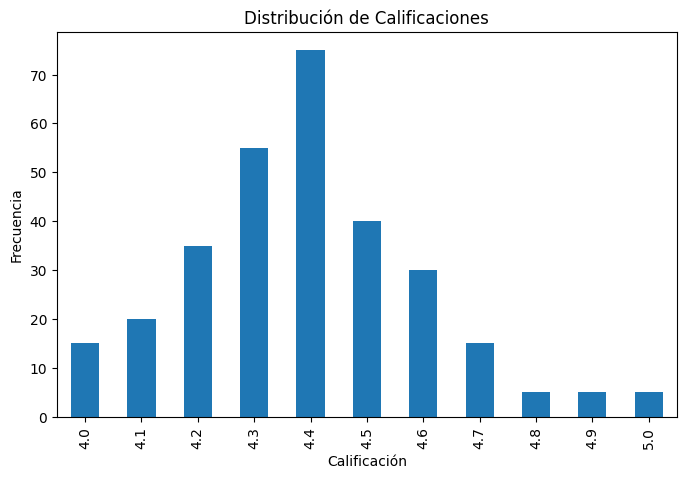

In [70]:
# Distribución de calificaciones
plt.figure(figsize=(8,5))
df['rating_lugar'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

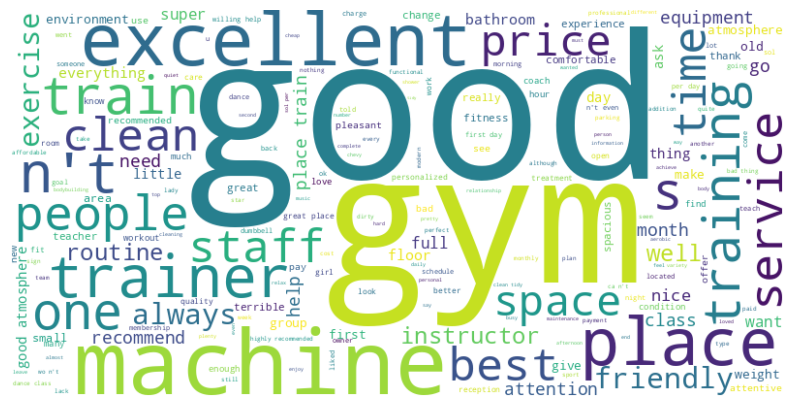

In [99]:
# Nube de palabras
all_words = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Paso 3: Análisis de Sentimiento ###

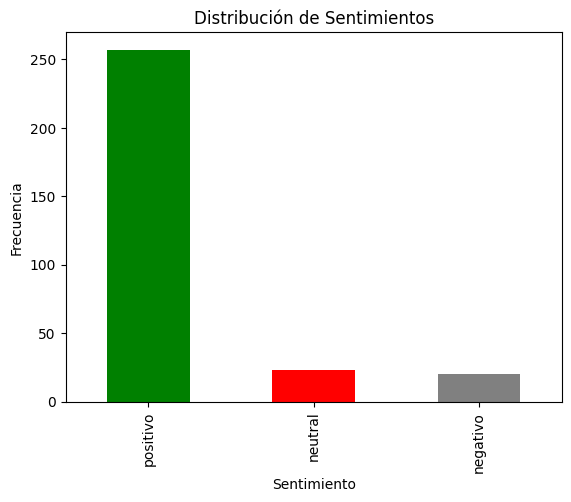

In [72]:
# Análisis de sentimiento con TextBlob
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'neutral'))
# Visualización de sentimiento
df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

### Paso 4: Modelado de Temas ###

In [73]:
# Asegúrate de que stop_words sea una lista
stop_words = list(stop_words)

# Crear la matriz de términos-frecuencia
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(df['clean_text'])


In [74]:
# Aplicar LDA para encontrar temas
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)
# Mostrar los temas
for index, topic in enumerate(lda.components_):
    print(f'Tema {index + 1}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Tema 1:
['thing', 'exercise', 'routine', 'place', 'great', 'machine', 'clean', 'good', 'gym', 'excellent']
Tema 2:
['class', 'bad', 'go', 'first', 'one', 'place', 'day', 'machine', 'gym', 'good']
Tema 3:
['train', 'atmosphere', 'excellent', 'help', 'nice', 'trainer', 'gym', 'place', 'machine', 'good']
Tema 4:
['trainer', 'full', 'best', 'training', 'machine', 'excellent', 'gym', 'place', 'good', 'train']
Tema 5:
['time', 'friendly', 'help', 'super', 'class', 'dont', 'good', 'always', 'people', 'gym']


### Paso 6: Comparación de Lugares ###

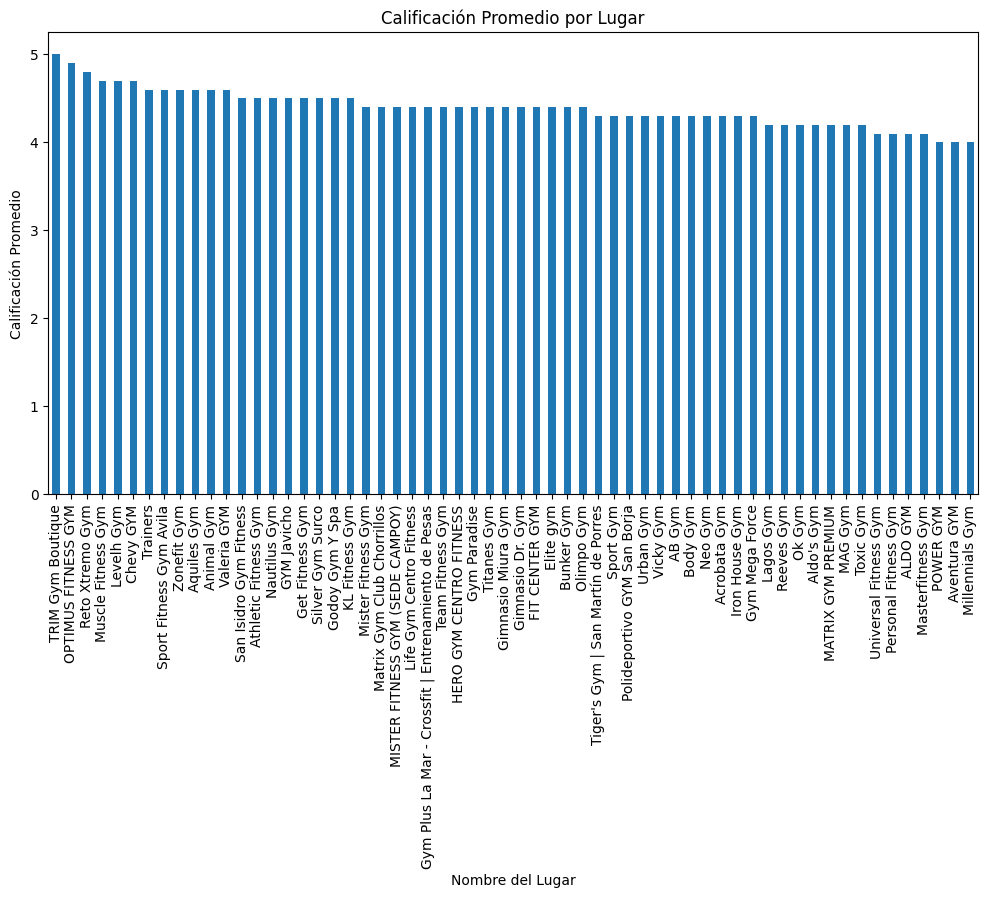

In [75]:
# Calificación promedio por lugar, ordenado de forma descendente
avg_rating_by_place = df.groupby('name')['rating_lugar'].mean().sort_values(ascending=False)

# Graficar el resultado
avg_rating_by_place.plot(kind='bar', figsize=(12, 6))
plt.title('Calificación Promedio por Lugar')
plt.xlabel('Nombre del Lugar')
plt.ylabel('Calificación Promedio')
plt.show()

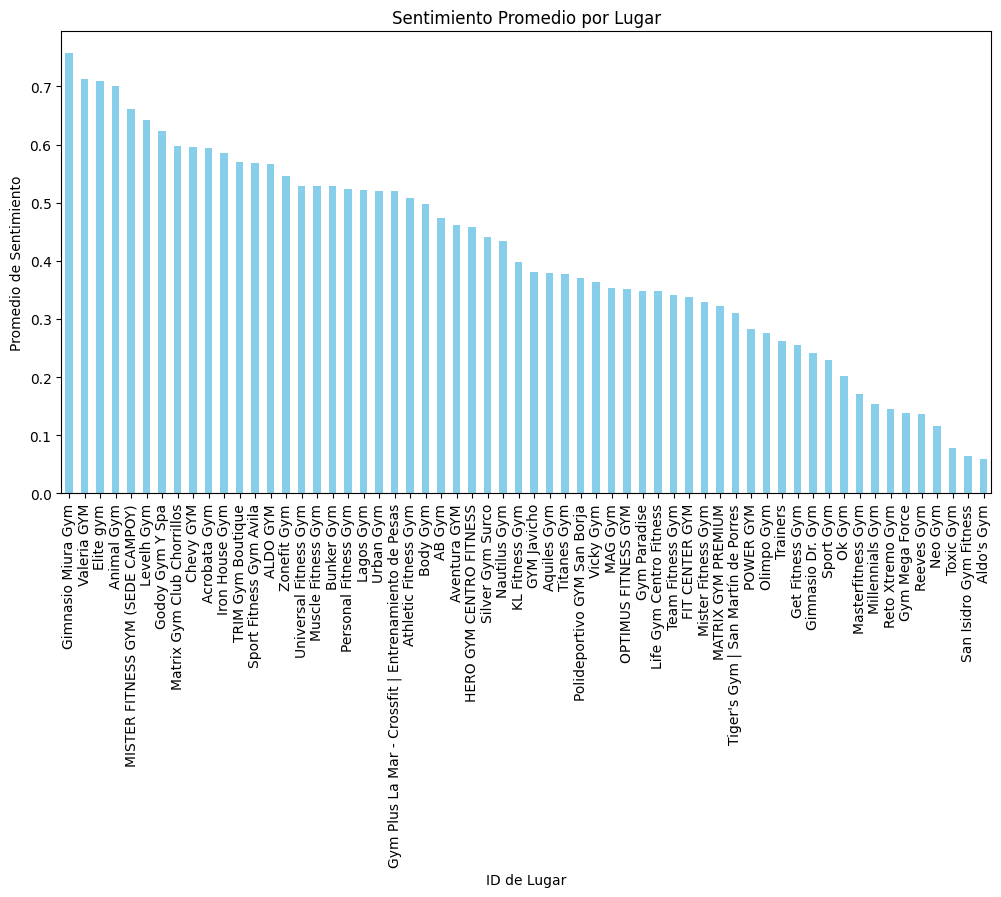

Análisis de text mining completado.


In [76]:
# Sentimiento promedio por lugar
avg_sentiment_by_place = df.groupby('name')['sentiment'].mean().sort_values(ascending=False)
avg_sentiment_by_place.plot(kind='bar', color='skyblue', figsize=(12, 6))
plt.title('Sentimiento Promedio por Lugar')
plt.xlabel('ID de Lugar')
plt.ylabel('Promedio de Sentimiento')
plt.show()

# Fin del análisis
print("Análisis de text mining completado.")

In [79]:
# Calcular el promedio de rating por cada tipo de negocio
average_rating_by_name = df.groupby([ 'name','user_ratings_total'])['rating_lugar'].mean().reset_index()

# Ordenar por la calificación promedio en orden descendente (mayor a menor)
average_rating_by_name_sorted = average_rating_by_name.sort_values(by='rating_lugar', ascending=False)

# Mostrar el resultado ordenado
average_rating_by_name_sorted

,name,user_ratings_total,rating_lugar
49,TRIM Gym Boutique,187,5.0
37,OPTIMUS FITNESS GYM,15,4.9
44,Reto Xtremo Gym,159,4.8
34,Muscle Fitness Gym,24,4.7
25,Levelh Gym,55,4.7
10,Chevy GYM,75,4.7
54,Trainers,245,4.6
47,Sport Fitness Gym Avila,32,4.6
59,Zonefit Gym,37,4.6
5,Aquiles Gym,76,4.6


In [81]:
import numpy as np

# Calcular C
C = average_rating_by_name_sorted['rating_lugar'].mean()

# Calcular m (por ejemplo, percentil 75)
m = average_rating_by_name_sorted['user_ratings_total'].quantile(0.75)

In [100]:
def calcular_calificacion_ponderada(row, m, C):
    v = row['user_ratings_total']
    R = row['rating_lugar']
    return (v / (v + m) * R) + (m / (v + m) * C)

average_rating_by_name_sorted['calificacion_ponderada'] = average_rating_by_name_sorted.apply(calcular_calificacion_ponderada, axis=1, args=(m, C))

In [101]:
# Ordenar por calificación ponderada
df_ordenado = average_rating_by_name_sorted.sort_values(by='calificacion_ponderada', ascending=False)

# Mostrar los primeros establecimientos
top10_establecimientos = df_ordenado[['name', 'user_ratings_total', 'rating_lugar', 'calificacion_ponderada']].head(10)
top10_establecimientos

,name,user_ratings_total,rating_lugar,calificacion_ponderada
49,TRIM Gym Boutique,187,5.0,4.754243
44,Reto Xtremo Gym,159,4.8,4.618876
54,Trainers,245,4.6,4.528968
10,Chevy GYM,75,4.7,4.506289
25,Levelh Gym,55,4.7,4.484972
5,Aquiles Gym,76,4.6,4.469760
37,OPTIMUS FITNESS GYM,15,4.9,4.445459
6,Athletic Fitness Gym,120,4.5,4.444352
34,Muscle Fitness Gym,24,4.7,4.440755
59,Zonefit Gym,37,4.6,4.438740


<ipython-input-87-c73799c4ca06>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='calificacion_ponderada', y='name', data=top10_establecimientos, palette='Blues_d')


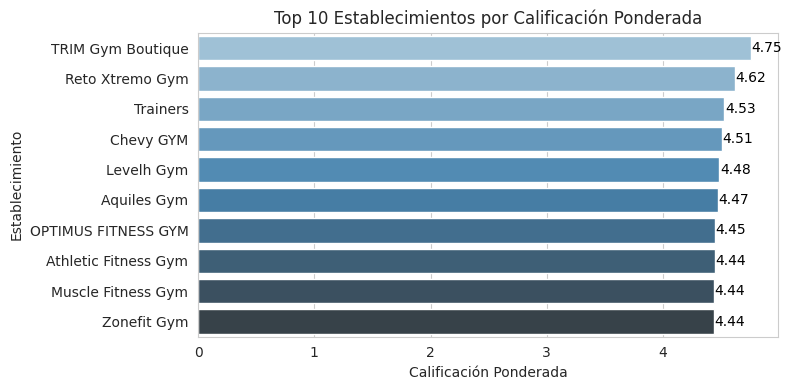

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
# Configurar el estilo de Seaborn
sns.set_style('whitegrid')

# Crear el gráfico de barras
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='calificacion_ponderada', y='name', data=top10_establecimientos, palette='Blues_d')

# Agregar etiquetas y título
plt.xlabel('Calificación Ponderada')
plt.ylabel('Establecimiento')
plt.title('Top 10 Establecimientos por Calificación Ponderada')

# Agregar etiquetas de valor al final de cada barra
for i, v in enumerate(top10_establecimientos['calificacion_ponderada']):
    ax.text(v + 0.005, i, f'{v:.2f}', color='black', va='center')

plt.tight_layout()
plt.show()